<a href="https://colab.research.google.com/github/khalil753/Bio-Project/blob/master/4_PerformanceEval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Description of the Notebook**

In this notebook the performance of the three different models is compared.

# **Instructions of use of the Notebook**

To make use of this notebook, one only needs to modify the "path" variable. After having modified the path variable, one may simple run the entire notebook.

# **Mounting libraries and defining global variables**

In [ ]:
import fastai
from fastai.vision import *
from fastai.widgets import *

import numpy as np
import pandas as pd

from pathlib import Path
import os
from os import listdir

import matplotlib as mpl
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import tensor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
sns.set()

In [ ]:
path = Path(r"")
path_data = path/'data'
path_losses = path/"Performance Metrics"/"Losses"

classes = ['healthy', 'tumor', 'injury']

def class2n(y):
  return tensor([*map(lambda x: {'healthy':0, 'tumor':1, 'injury':2}[x], y)])

def low_loss_idx(loss, idx, th):
  n_good = (loss <= th).sum()
  return idx[-n_good:]

def conf_mat(preds, y):
  c = y.max() + 1
  preds = preds.argmax(1)
  cf = np.zeros((c,c))
  for pred, true in zip(preds, y):
    cf[true, pred] += 1
  return cf


# **Evaluating performance**

## *Comparing Accuracies*

In [ ]:
data = pd.read_csv(path_data/'Clean Data'/'val.csv')
y = class2n(data['y'])
for n in range(1,4):
  exec(f'preds{n} = tensor(np.load(path_data/"Preds"/"p{n}.npy"))')
  exec(f'acc{n} = accuracy(preds{n}, y)')

acc1, acc2, acc3

(tensor(0.7062), tensor(0.7210), tensor(0.7158))

In [ ]:
cf1 = conf_mat(preds1, y)
cf2 = conf_mat(preds2, y)
cf3 = conf_mat(preds3, y)

print("Model 1's Confusion Matrix:\n")
print(cf1,'\n')
print("Model 2's Confusion Matrix:\n")
print(cf2,'\n')
print("Model 3's Confusion Matrix:\n")
print(cf3)

Model 1's Confusion Matrix:

[[1786.  214.  874.]
 [ 275. 1493.  446.]
 [ 186.  152. 1882.]] 

Model 2's Confusion Matrix:

[[2011.  526.  337.]
 [ 364. 1768.   82.]
 [ 347.  383. 1490.]] 

Model 3's Confusion Matrix:

[[2001.  279.  594.]
 [ 390. 1511.  313.]
 [ 315.  186. 1719.]]


## *Studying performance in Low Loss Samples*

In this part we compare the accuracy of the different models on samples with low losses. To do so, a loss threshold is defined, and accuracy of the models is calculated for the samples with a loss below the threshold. Several thresholds were chosen and a plot was made of how the accuracy changes as a function of these loss thresholds.

In [ ]:
for n in range(1,4):
  exec(f'loss{n} = torch.load(path_data/"Losses"/"val_losses{n}.pt")')
  exec(f'idx{n} = torch.load(path_data/"Losses"/"val_idxs{n}.pt")')

In [ ]:
ths = np.linspace(0,3, 3000)      # list of loss thresholds
accs1, accs2, accs3 = [], [], []
for th in ths:
  for n in range(1,4):
    exec(f'll_idx{n} = low_loss_idx(loss{n}, idx{n}, th)')
    exec(f'preds{n} = tensor(np.load(path_data/"Preds"/"p{n}.npy"))')
    exec(f'acc{n} = accuracy(preds{n}[ll_idx{n}], y[ll_idx{n}])*100')
    exec(f'accs{n}.append(acc{n})')

Here we plot the accuracies of the models as a function of the loss threshold. The second plot shows the same curve on the range of loss thresholds from 0.8 to 1.25.

Text(0, 0.5, 'Accuracy')

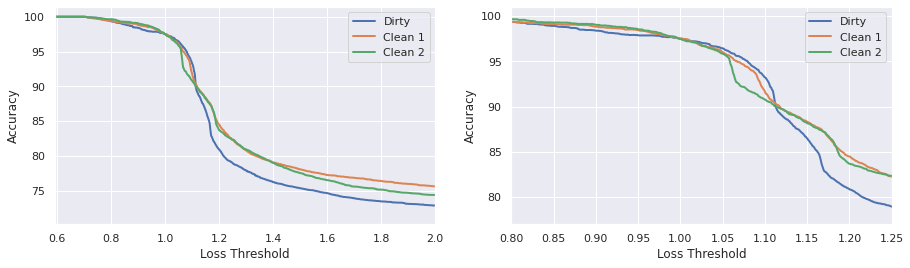

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))
lines0 = ax[0].plot(ths, accs1, ths, accs2, ths, accs3, lw=2)    
lines1 = ax[1].plot(ths, accs1, ths, accs2, ths, accs3, lw=2)    

ax[0].legend(lines0, ('Dirty', 'Clean 1', 'Clean 2'))
ax[0].set_xlim((0.59,2))
ax[0].set_xlabel("Loss Threshold")
ax[0].set_ylabel("Accuracy")

ax[1].legend(lines1, ('Dirty', 'Clean 1', 'Clean 2'))
ax[1].set_xlim((0.8,1.25))
ax[1].set_ylim((77,101))
ax[1].set_xlabel("Loss Threshold")
ax[1].set_ylabel("Accuracy")


From the curves one can see that for validation samples with a loss below 1 the "clean" models perform better than the "dirty" one, with "clean 2" having a (maybe negligibly) better accuracy. Between 1 and 1.1 (the range in which the lump in the loss histograms appears), the dirty model performs better. After 1.1 the clean models retake the lead in performance, "clean 1" having the best accuracies.

## *Number of sampels of each class*

This part of the code shows the number of samples of each class, at the different different stages of "cleanliness" of the trianing data.

In [ ]:
ns1 = np.zeros(3, dtype=np.int)
ns2 = np.zeros(3, dtype=np.int)
ns3 = np.zeros(3, dtype=np.int)
for i, label in enumerate(classes):
  ns1[i] = len(data.loc[data['y']==label])

for i, label in enumerate(classes):
  ns2[i] = len(data.loc[data['y']==label].loc[data['clean']==True])

for i, label in enumerate(classes):
  ns3[i] = len(data.loc[data['y']==label].loc[data['clean2']==True])

ns = pd.DataFrame(np.array([ns1,ns2,ns3]).T, index=['healthy', 'tumor', 'injury'], columns=['Dirty', 'Clean 1', 'Clean 2'])
ns 

,Dirty,Clean 1,Clean 2
healthy,2874,1767,2030
tumor,2214,1469,1481
injury,2220,1681,1601


This part shows the removal rate of each class, at the different stages of cleanliness. 

In [ ]:
rr = (ns1[:,None] - ns.iloc[:,1:3])*100/ ns1[:,None]
rr.round(decimals=2)

,Clean 1,Clean 2
healthy,38.52,29.37
tumor,33.65,33.11
injury,24.28,27.88
